In [1]:
import numpy as np
import os 
import cv2
import tensorflow as tf 
import keras 
import matplotlib.pyplot as plt 
import h5py
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate  
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
folder=os.listdir('/kaggle/input/brain-tumor-segmentation')
folder

['images', 'masks']

In [3]:
image_files=sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/images'))
mask_files=sorted(os.listdir('/kaggle/input/brain-tumor-segmentation/masks'))

print(image_files[:10])
print(mask_files[:10])

['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']
['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']


In [4]:
def display_image_mask(image_path,mask_path):
    count=0
    for image_file,mask_file in zip(image_files,mask_files):
        if count>=6:
            break
        image_path_full=os.path.join(image_path,image_file)
        mask_path_full=os.path.join(mask_path,mask_file)

        image=cv2.imread(image_path_full)
        mask=cv2.imread(mask_path_full,cv2.IMREAD_GRAYSCALE)

        if image is None:
                raise ValueError(f"Image at path {imagepath_full} could not be loaded")
        if mask is None:
                raise ValueError(f"Mask at path {maskpath_full} could not be loaded")

        mask_3ch=cv2.merge([mask,mask,mask])
        image_rgb=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,10))
        
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(mask)
        plt.title('Mask')

        plt.subplot(1,3,3) 
        overlay = cv2.addWeighted(image_rgb, 0.7, mask_3ch, 0.3, 0)
        plt.imshow(overlay)
        plt.title("Image with overlay")

        plt.show()
        count+=1

In [5]:
image_path='/kaggle/input/brain-tumor-segmentation/images'
mask_path='/kaggle/input/brain-tumor-segmentation/masks'

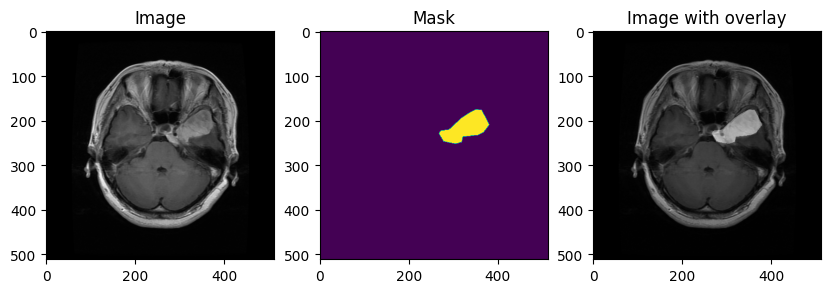

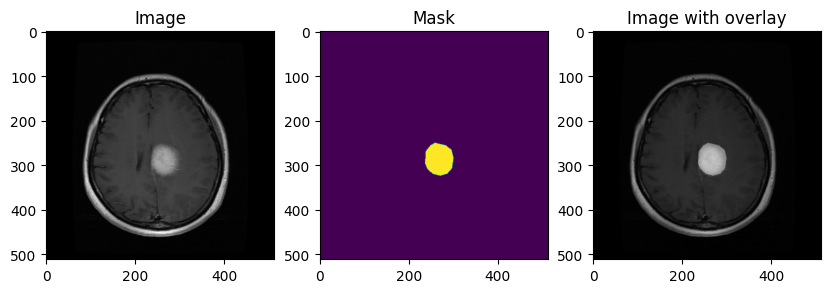

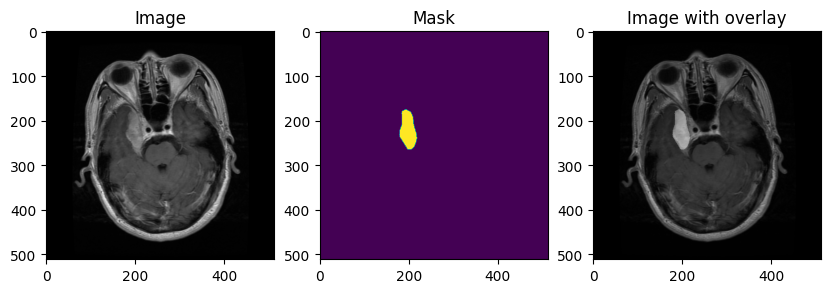

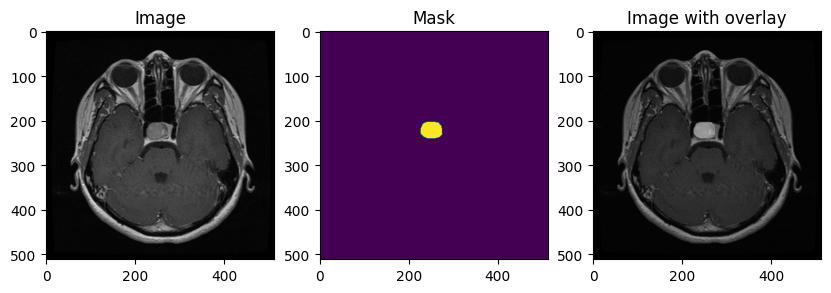

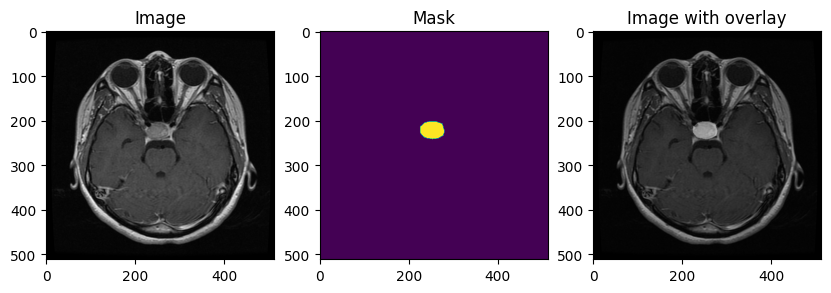

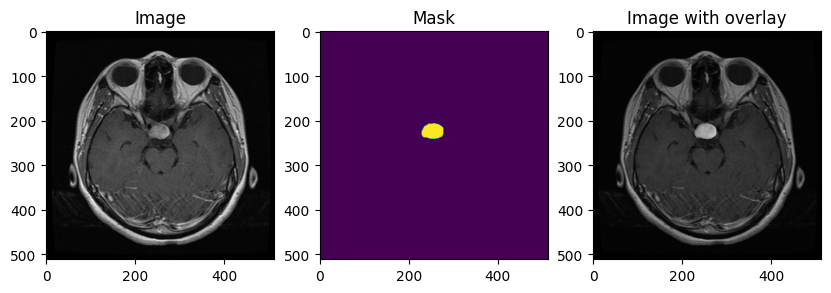

In [6]:
display_image_mask(image_path,mask_path)

In [7]:
image=cv2.imread('/kaggle/input/brain-tumor-segmentation/images/1.png')
mask=cv2.imread('/kaggle/input/brain-tumor-segmentation/masks/1.png')

print(image.shape)
print(mask.shape)

(512, 512, 3)
(512, 512, 3)


In [8]:
images_size=[]
masks_size=[]

for image_file, mask_file in tqdm(zip(image_files, mask_files)):


    imagepath_full = os.path.join(image_path, image_file)
    maskpath_full = os.path.join(mask_path, mask_file)

    image = cv2.imread(imagepath_full)
    mask = cv2.imread(maskpath_full)

    images_size.append(image.shape)
    masks_size.append(mask.shape)

3064it [01:07, 45.21it/s]


In [9]:
print(list(set(images_size)))
print(list(set(masks_size)))

[(512, 512, 3), (256, 256, 3)]
[(512, 512, 3), (256, 256, 3)]


In [10]:
SIZE=224
CHANNEL=1

In [11]:
def preprocessing_images_masks():
    images=[]
    masks=[]

    for image_file, mask_file in tqdm(zip(image_files,mask_files)):
        imagepathfull=os.path.join(image_path,image_file)
        maskpathfull=os.path.join(mask_path,mask_file)

        image = cv2.imread(imagepathfull,cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(SIZE,SIZE))
        image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image = image/255.0
        images.append(image)

        mask = cv2.imread(maskpathfull,cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask,(SIZE,SIZE))
        mask = mask/255.0
        masks.append(mask)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

In [12]:
X,y=preprocessing_images_masks()

3064it [00:22, 137.42it/s]


In [13]:
print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

Shape of X: (3064, 224, 224, 3)
Shape of y: (3064, 224, 224, 1)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
print('The shape of X_train',X_train.shape)
print('The shape of y_train',y_train.shape)
print('The shape of X_test',X_test.shape)
print('The shape of y_test',y_test.shape)

The shape of X_train (2451, 224, 224, 3)
The shape of y_train (2451, 224, 224, 1)
The shape of X_test (613, 224, 224, 3)
The shape of y_test (613, 224, 224, 1)


In [16]:
smooth = 1e-15
@keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [17]:
train_datagen=ImageDataGenerator(brightness_range=(0.9,1.1),
                                 zoom_range=[.9,1.1],
                                 fill_mode='nearest')
val_datagen=ImageDataGenerator()

In [18]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(shape=input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output         ## (512 x 512)
    s2 = vgg16.get_layer("block2_conv2").output         ## (256 x 256)
    s3 = vgg16.get_layer("block3_conv3").output         ## (128 x 128)
    s4 = vgg16.get_layer("block4_conv3").output         ## (64 x 64)

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output         ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model


input_shape = (224,224, 3)
model = build_vgg16_unet(input_shape)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "VGG16_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 224, 224, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 112, 112, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 112, 112, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 112, 112, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 56, 56, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 56, 56, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 56, 56, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 28, 28, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 28, 28, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 28, 28, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 14, 14, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 14, 14, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 25,862,337 (98.66 MB)

 Trainable params: 25,858,497 (98.64 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [19]:
model_checkpoint  = ModelCheckpoint('model_best_checkpoint.keras', save_best_only=True,
                                    monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

In [20]:
batch_size = 16

train_generator = train_datagen.flow( X_train, y_train, batch_size=batch_size, shuffle=True)

val_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=dice_loss,
              metrics=[dice_coef, 'accuracy'])



In [22]:
history = model.fit(
    X_train, y_train, batch_size=32, epochs=100,validation_data=(X_test, y_test),verbose=1,callbacks=callback_list)


Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7336 - dice_coef: 0.0460 - loss: 0.9540
Epoch 1: val_loss improved from inf to 0.95459, saving model to model_best_checkpoint.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.7331 - dice_coef: 0.0461 - loss: 0.9539 - val_accuracy: 0.6643 - val_dice_coef: 0.0471 - val_loss: 0.9546 - learning_rate: 1.0000e-05
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6410 - dice_coef: 0.0672 - loss: 0.9328
Epoch 2: val_loss improved from 0.95459 to 0.91919, saving model to model_best_checkpoint.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.6411 - dice_coef: 0.0673 - loss: 0.9327 - val_accuracy: 0.7892 - val_dice_coef: 0.0840 - val_loss: 0.9192 - learning_rate: 1.0000e-05
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7799 - dice_coef: 0.1005 - loss: 0.8995
Epoch 3: val_loss improved from 0.91919 to 0.89964, saving model to model_best_checkpoint.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1

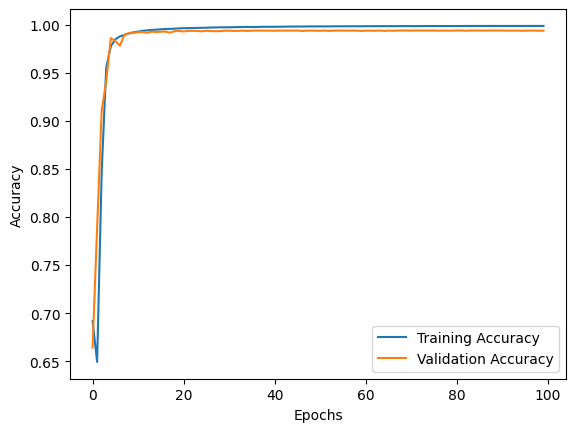

In [23]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

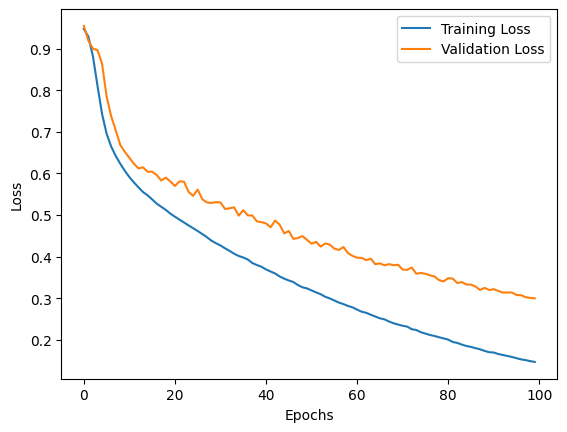

In [24]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
accuracy,dice_coef,loss=model.evaluate(X_test,y_test)
print(f'Loss is {loss}')
print(f'Accuracy is {accuracy}')
print(f'Dice_Coef is {dice_coef}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 509ms/step - accuracy: 0.9938 - dice_coef: 0.7002 - loss: 0.3001
Loss is 0.9936462640762329
Accuracy is 0.29984405636787415
Dice_Coef is 0.7035137414932251


In [26]:
model.save("unet_vgg16_backbone.keras")